# US Flight data analysis - Part 1
  
'Data Analysis with Python' by David Taieb.  Published by Packt Publishing, 2018: https://learning.oreilly.com/library/view/data-analysis-with/9781789950069/ch09s03.html  
https://github.com/PacktPublishing/Thoughtful-Data-Science/tree/master/Chapter09  

  
1. Load data into Pandas DataFrames using pixiedust.sampleData()
2. Create a networkx DiGraph from the flights DataFrame
3. Augment the airports DataFrame with columns that compute the different centrality indices
4. Visualize airports using networkx drawing APIs and pixiedust display() Mapbox Map
5. Compute the Dikjstra shorted path between 2 airports using ELAPSED_TIME and the centrality indices as weight


### Pixiedust
is an open source Python helper library that works as an add-on to Jupyter notebooks to improve the user experience of working with data: https://pixiedust.github.io/pixiedust/index.html

To install from command line: 
```python
pip install pixiedust
```

In [2]:
import pixiedust
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.cm as cm

Pixiedust database opened successfully


### Load Airports
List of all U.S. airports including their IATA code (International Air Transport Association), city, state, longitude, and latitude.

Airports Data: https://openflights.org/data.html

In [3]:
airports = pixiedust.sampleData("https://github.com/DTAIEB/Thoughtful-Data-Science/raw/master/chapter%209/USFlightsAnalysis/airports.csv")

Downloaded 23867 bytes
Creating pandas DataFrame for 'https://github.com/DTAIEB/Thoughtful-Data-Science/raw/master/chapter%209/USFlightsAnalysis/airports.csv'. Please wait...
Loading file using 'pandas'
Successfully created pandas DataFrame for 'https://github.com/DTAIEB/Thoughtful-Data-Science/raw/master/chapter%209/USFlightsAnalysis/airports.csv'


In [ ]:
##download as file
display(airports)

Load airlines - list of U.S. airlines including their IATA code.

In [5]:
airlines = pixiedust.sampleData("https://github.com/DTAIEB/Thoughtful-Data-Science/raw/master/chapter%209/USFlightsAnalysis/airlines.csv")

Downloaded 359 bytes
Creating pandas DataFrame for 'https://github.com/DTAIEB/Thoughtful-Data-Science/raw/master/chapter%209/USFlightsAnalysis/airlines.csv'. Please wait...
Loading file using 'pandas'
Successfully created pandas DataFrame for 'https://github.com/DTAIEB/Thoughtful-Data-Science/raw/master/chapter%209/USFlightsAnalysis/airlines.csv'


In [6]:
airlines.head(10)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


Load flights - list of flights that occurred in 2015. This data includes date, origin and destination airports, scheduled and actual times, and delays.

In [7]:
flights = pixiedust.sampleData("https://github.com/DTAIEB/Thoughtful-Data-Science/raw/master/chapter%209/USFlightsAnalysis/flights.zip")

Extracting first item in zip file...
File extracted: flights.csv
Downloaded 86144241 bytes
Creating pandas DataFrame for 'https://github.com/DTAIEB/Thoughtful-Data-Science/raw/master/chapter%209/USFlightsAnalysis/flights.zip'. Please wait...
Loading file using 'pandas'
Successfully created pandas DataFrame for 'https://github.com/DTAIEB/Thoughtful-Data-Science/raw/master/chapter%209/USFlightsAnalysis/flights.zip'


In [8]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,DEPARTURE_DELAY,ELAPSED_TIME,AIR_TIME,DISTANCE,ARRIVAL_DELAY,CANCELLED
0,2015,1,1,4,AS,98,ANC,SEA,2015-01-01 23:54:00,-11.0,194.0,169.0,1448,-22.0,0
1,2015,1,1,4,AA,2336,LAX,PBI,2015-01-01 00:02:00,-8.0,279.0,263.0,2330,-9.0,0
2,2015,1,1,4,US,840,SFO,CLT,2015-01-01 00:18:00,-2.0,293.0,266.0,2296,5.0,0
3,2015,1,1,4,AA,258,LAX,MIA,2015-01-01 00:15:00,-5.0,281.0,258.0,2342,-9.0,0
4,2015,1,1,4,AS,135,SEA,ANC,2015-01-01 00:24:00,-1.0,215.0,199.0,1448,-21.0,0


In [9]:
edges = flights.groupby(["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])[["ELAPSED_TIME"]].mean()
edges

ELAPSED_TIME
ORIGIN_AIRPORT DESTINATION_AIRPORT              
ABE            ATL                    127.415350
               DTW                    101.923741
               ORD                    130.298762
ABI            DFW                     53.951591
ABQ            ATL                    174.822278
...                                          ...
XNA            SFO                    249.901961
               SLC                    155.000000
YAK            CDV                     49.193846
               JNU                     45.956923
YUM            PHX                     57.270227

[4656 rows x 1 columns]

Reset the index from a multi-index to a regular single index converting the index columns into regular columns.

In [10]:
edges = edges.reset_index()
edges.head(10)

,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ELAPSED_TIME
0,ABE,ATL,127.415350
1,ABE,DTW,101.923741
2,ABE,ORD,130.298762
3,ABI,DFW,53.951591
4,ABQ,ATL,174.822278
5,ABQ,BWI,215.028112
6,ABQ,CLT,193.168421
7,ABQ,DAL,95.107051
8,ABQ,DEN,75.268199
9,ABQ,DFW,103.641714


Load the data into a networkx directed weighted graph object using the flights DataFrame as the edge list and the values from the ELAPSED_TIME column as the weight.  Elapsed flying time is the actual time an airplane spends in the air.  
  
To create the directed weighted graph, we use the NetworkX ***from_pandas_edgelist()*** method which takes a pandas DataFrame as the input source. We also specify the source and target columns, as well as the weight column. Finally, we tell NetworkX that we want to create a directed graph by using the create_using keyword arguments, passing an instance of DiGraph as a value.
  
Weighted graph example: https://qxf2.com/blog/drawing-weighted-graphs-with-networkx/

In [11]:
flight_graph = nx.from_pandas_edgelist(
    df=edges, 
    source="ORIGIN_AIRPORT",
    target="DESTINATION_AIRPORT", 
    edge_attr="ELAPSED_TIME", # weight
    create_using = nx.DiGraph() )

We can quickly validate that our graph has the right values by directly printing its nodes and edges:

In [12]:
print("Nodes: {}".format(flight_graph.nodes))

Nodes: ['ABE', 'ATL', 'DTW', 'ORD', 'ABI', 'DFW', 'ABQ', 'BWI', 'CLT', 'DAL', 'DEN', 'HOU', 'IAH', 'JFK', 'LAS', 'LAX', 'MCI', 'MCO', 'MDW', 'MSP', 'OAK', 'PDX', 'PHX', 'SAN', 'SEA', 'SFO', 'SLC', 'ABR', 'ABY', 'ACK', 'BOS', 'DCA', 'ACT', 'ACV', 'ACY', 'FLL', 'MYR', 'PBI', 'RSW', 'TPA', 'ADK', 'ANC', 'ADQ', 'AEX', 'AGS', 'LGA', 'AKN', 'ALB', 'EWR', 'IAD', 'ALO', 'AMA', 'BET', 'BRW', 'CDV', 'DLG', 'FAI', 'HNL', 'JNU', 'KOA', 'LGB', 'OGG', 'OME', 'OTZ', 'SCC', 'APN', 'ASE', 'ATW', 'AUS', 'AVL', 'AVP', 'AZO', 'BDL', 'BHM', 'BMI', 'BNA', 'BQK', 'BTR', 'BTV', 'BUF', 'BZN', 'CAE', 'CAK', 'CHA', 'CHO', 'CHS', 'CID', 'CLE', 'CMH', 'COS', 'CRW', 'CSG', 'CVG', 'DAB', 'DAY', 'DHN', 'DSM', 'ECP', 'EGE', 'ELM', 'ELP', 'EVV', 'EWN', 'EYW', 'FAR', 'FAY', 'FCA', 'FNT', 'FSD', 'FSM', 'FWA', 'GNV', 'GPT', 'GRB', 'GRK', 'GRR', 'GSO', 'GSP', 'GTR', 'HDN', 'HPN', 'HSV', 'ICT', 'ILM', 'IND', 'JAC', 'JAN', 'JAX', 'LAN', 'LEX', 'LFT', 'LIT', 'LNK', 'MBS', 'MDT', 'MEM', 'MGM', 'MHT', 'MIA', 'MKE', 'MLB', 'MLI'

In [13]:
print("Edges: {}".format(flight_graph.edges))

Edges: [('ABE', 'ATL'), ('ABE', 'DTW'), ('ABE', 'ORD'), ('ATL', 'ABE'), ('ATL', 'ABQ'), ('ATL', 'ABY'), ('ATL', 'ACY'), ('ATL', 'AEX'), ('ATL', 'AGS'), ('ATL', 'ALB'), ('ATL', 'ANC'), ('ATL', 'ASE'), ('ATL', 'ATW'), ('ATL', 'AUS'), ('ATL', 'AVL'), ('ATL', 'AVP'), ('ATL', 'AZO'), ('ATL', 'BDL'), ('ATL', 'BHM'), ('ATL', 'BMI'), ('ATL', 'BNA'), ('ATL', 'BOS'), ('ATL', 'BQK'), ('ATL', 'BTR'), ('ATL', 'BTV'), ('ATL', 'BUF'), ('ATL', 'BWI'), ('ATL', 'BZN'), ('ATL', 'CAE'), ('ATL', 'CAK'), ('ATL', 'CHA'), ('ATL', 'CHO'), ('ATL', 'CHS'), ('ATL', 'CID'), ('ATL', 'CLE'), ('ATL', 'CLT'), ('ATL', 'CMH'), ('ATL', 'COS'), ('ATL', 'CRW'), ('ATL', 'CSG'), ('ATL', 'CVG'), ('ATL', 'DAB'), ('ATL', 'DAL'), ('ATL', 'DAY'), ('ATL', 'DCA'), ('ATL', 'DEN'), ('ATL', 'DFW'), ('ATL', 'DHN'), ('ATL', 'DSM'), ('ATL', 'DTW'), ('ATL', 'ECP'), ('ATL', 'EGE'), ('ATL', 'ELM'), ('ATL', 'ELP'), ('ATL', 'EVV'), ('ATL', 'EWN'), ('ATL', 'EWR'), ('ATL', 'EYW'), ('ATL', 'FAR'), ('ATL', 'FAY'), ('ATL', 'FCA'), ('ATL', 'FLL'), 

Default graph layout called **spring_layout**, which is a force-directed layout.  The nodes in the graph are positioned as if they are connected by springs and their final positions determined by a minimum of stretching of the edges.  
  
A **spring layout** is a Fruchterman-Reingold force-directed layout algorithm.  The idea is to consider a force between any two nodes. In this algorithm, the nodes are represented by steel rings and the edges are springs between them. The **attractive force** is analogous to the spring force and the **repulsive force** is analogous to the electrical force. The basic idea is to minimize the energy of the system by moving the nodes and changing the forces between them.   

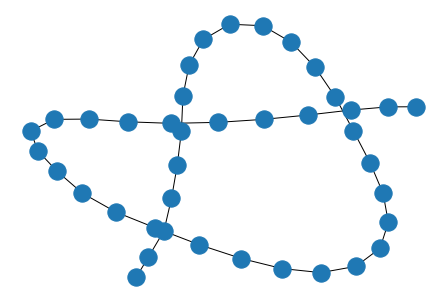

In [14]:
G=nx.path_graph(40)
pos=nx.spring_layout(G)
nx.draw(G)

The NetworkX ***draw()*** method uses Matplotlib engine. 
  
To beautify the visualization:
- we configure it with proper width and height (12, 12); 
- add a colormap with vivid color (we use the cool and spring colormap from matplolib.cm, see: https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html ).

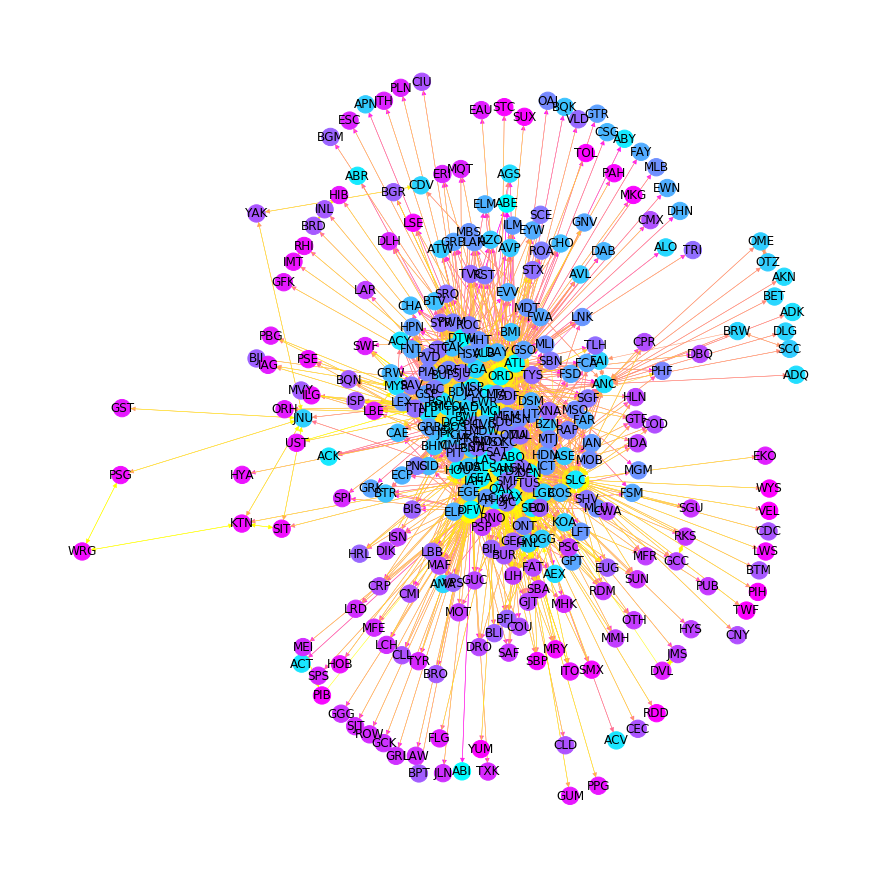

In [15]:
fig = plt.figure(figsize = (12,12))

nx.draw(flight_graph, arrows=True, with_labels=True,
        width = 0.5, style="dotted",
        node_color=range(len(flight_graph)),
        cmap=cm.get_cmap(name="cool"),
        edge_color=range(len(flight_graph.edges)),
        edge_cmap=cm.get_cmap(name="spring"))

plt.show()

#plt.savefig()

One benefit of the spring layout is that it quickly reveals the nodes with the most edge connections which are located at the center of the graph.  
  
networkx supports other types of layout including circular_layout, random_layout, shell_layout, and spectral_layout.  

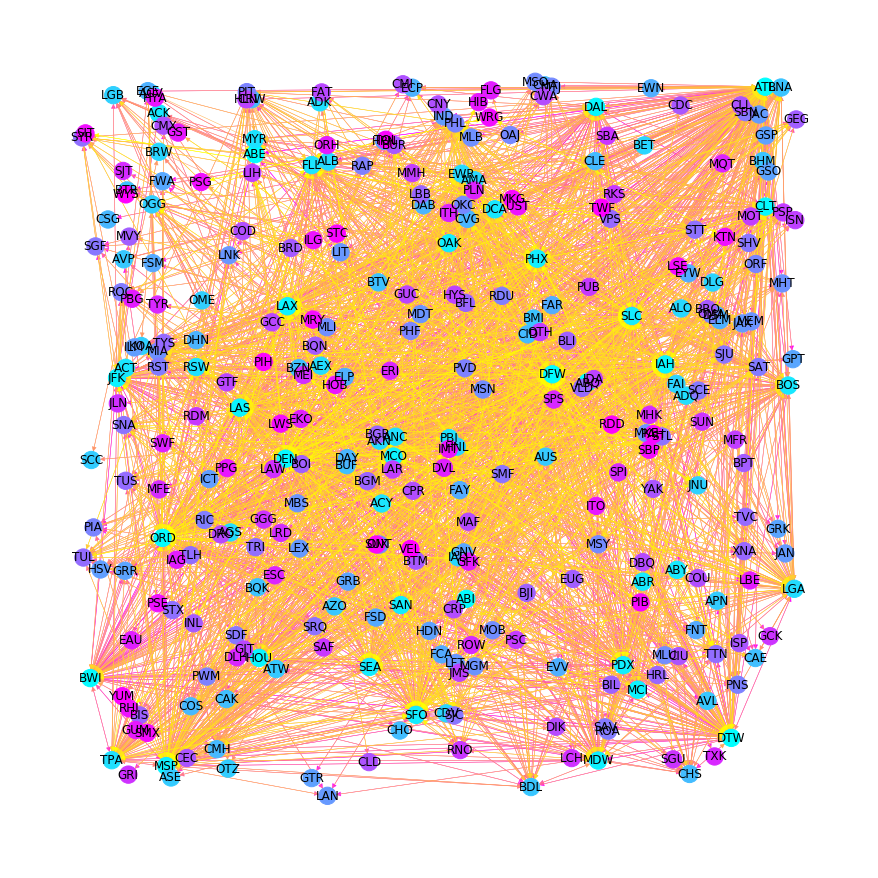

In [16]:
fig = plt.figure(figsize = (12,12))
nx.draw(flight_graph, 
        arrows=True, 
        with_labels=True, 
        width = 0.5,
        style="dotted",
        node_color=range(len(flight_graph)), 
        cmap=cm.get_cmap(name="cool"),
        edge_color=range(len(flight_graph.edges)), 
        edge_cmap=cm.get_cmap(name="spring"),
        pos = nx.random_layout(flight_graph)
       )
plt.show()

## Centrality
**Centrality** indices allow us to discover which nodes are the most important vertices.  
  
The case study calculates the following four types of centrality index: **degree, PageRank, closeness**, and **shortest path betweenness.**  We'll then augment the airports DataFrame to add a column for each of the centrality indices and visualize the results in a Mapbox map using PixieDust *display()*.

A node's **degree** is simply a count of how many social connections (i.e., edges) it has. 

**PageRank** is an algorithm used by Google Search to rank websites in their search engine results.  PageRank was named after Larry Page, one of the founders of Google. PageRank is a way of measuring the importance of website pages. According to Google:
*<ul>PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites.</ul>*
More on PageRank: https://towardsdatascience.com/graphs-and-paths-pagerank-54f180a1aa0a  
NetworkX documentation: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html  
  
  
**Closeness** centrality is a way of detecting nodes that are able to spread information very efficiently through a graph.  For each node, the Closeness Centrality algorithm calculates the sum of its distances to all other nodes, based on calculating the shortest paths between all pairs of nodes. The resulting sum is then inverted to determine the closeness centrality score for that node.  
https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/closeness-centrality/
  
**Betweenness centrality** is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another.  
https://neo4j.com/blog/graph-algorithms-neo4j-betweenness-centrality/

In [17]:
dict(flight_graph.degree)

{'ABE': 6,
 'ATL': 336,
 'DTW': 224,
 'ORD': 323,
 'ABI': 2,
 'DFW': 297,
 'ABQ': 46,
 'BWI': 134,
 'CLT': 138,
 'DAL': 104,
 'DEN': 279,
 'HOU': 102,
 'IAH': 238,
 'JFK': 128,
 'LAS': 156,
 'LAX': 161,
 'MCI': 80,
 'MCO': 148,
 'MDW': 138,
 'MSP': 240,
 'OAK': 69,
 'PDX': 95,
 'PHX': 157,
 'SAN': 93,
 'SEA': 146,
 'SFO': 161,
 'SLC': 179,
 'ABR': 2,
 'ABY': 2,
 'ACK': 6,
 'BOS': 124,
 'DCA': 115,
 'ACT': 2,
 'ACV': 2,
 'ACY': 20,
 'FLL': 120,
 'MYR': 34,
 'PBI': 50,
 'RSW': 79,
 'TPA': 122,
 'ADK': 2,
 'ANC': 60,
 'ADQ': 2,
 'AEX': 6,
 'AGS': 5,
 'LGA': 138,
 'AKN': 2,
 'ALB': 29,
 'EWR': 173,
 'IAD': 138,
 'ALO': 2,
 'AMA': 10,
 'BET': 2,
 'BRW': 5,
 'CDV': 4,
 'DLG': 2,
 'FAI': 9,
 'HNL': 56,
 'JNU': 14,
 'KOA': 24,
 'LGB': 24,
 'OGG': 36,
 'OME': 4,
 'OTZ': 4,
 'SCC': 4,
 'APN': 2,
 'ASE': 16,
 'ATW': 8,
 'AUS': 83,
 'AVL': 6,
 'AVP': 8,
 'AZO': 8,
 'BDL': 50,
 'BHM': 30,
 'BMI': 14,
 'BNA': 93,
 'BQK': 2,
 'BTR': 8,
 'BTV': 14,
 'BUF': 36,
 'BZN': 24,
 'CAE': 13,
 'CAK': 24,
 'CHA

In [18]:
degree_df = pd.DataFrame([{"IATA_CODE":k, "DEGREE":v} for k,v in flight_graph.degree], columns=["IATA_CODE", "DEGREE"])

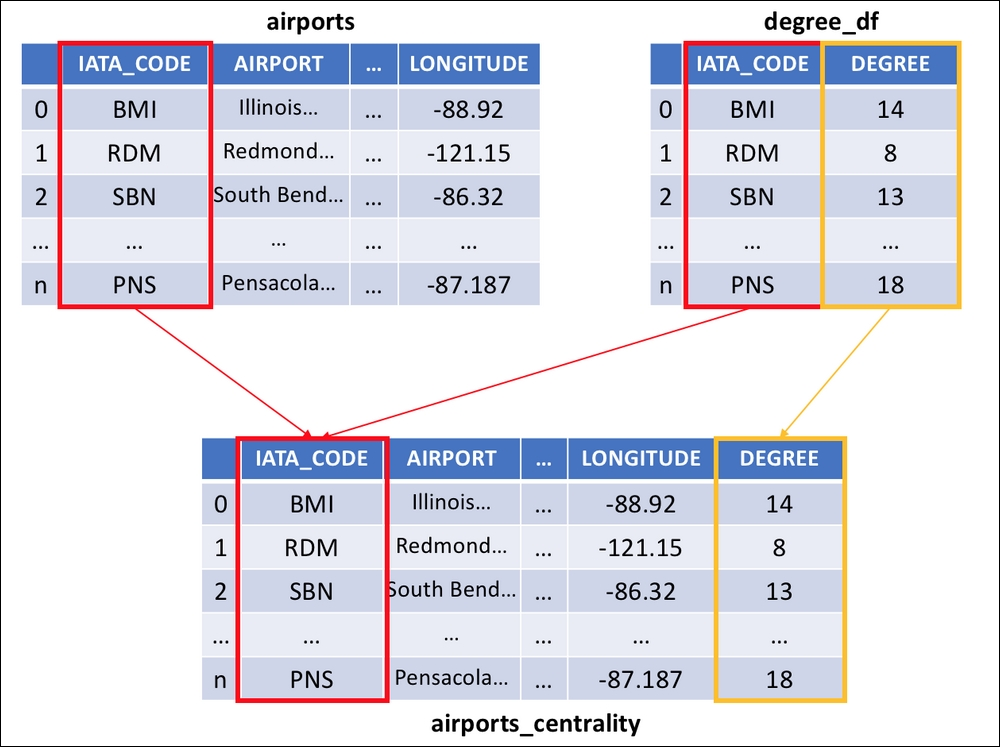

In [19]:
Image("img/US_flight_merge.jpg")

In [20]:
airports_centrality = pd.merge(airports, degree_df, on='IATA_CODE')

In [21]:
airports_centrality

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,DEGREE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,6
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,2
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,46
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,2
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,2
...,...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982,4
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764,2
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681,22
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023,4


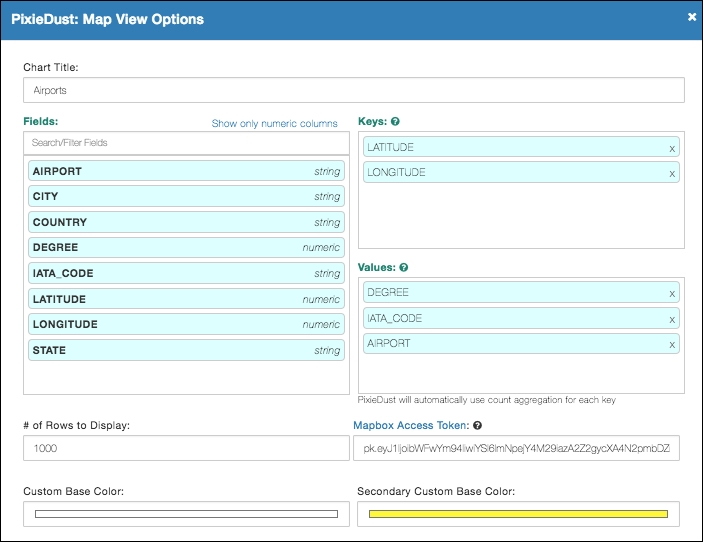

In [22]:
Image("img/US_flight_map_config.jpg")

In [24]:
from six import iteritems
def compute_centrality(g, centrality_df, compute_fn, col_name, *args, **kwargs): 
    # create a temporary DataFrame that contains the computed centrality values
    temp_df = pd.DataFrame(
        [{"IATA_CODE":k, col_name:v} for k,v in iteritems(compute_fn(g, *args, **kwargs))], 
        columns=["IATA_CODE", col_name]
    )
    # make sure to remove the col_name from the centrality_df is already there
    if col_name in centrality_df.columns:
        centrality_df.drop([col_name], axis=1, inplace=True)
    # merge the 2 DataFrame on the IATA_CODE column
    centrality_df = pd.merge(centrality_df, temp_df, on='IATA_CODE')
    return centrality_df

In [25]:
airports_centrality = compute_centrality(flight_graph, airports_centrality, nx.pagerank, "PAGE_RANK")
airports_centrality = compute_centrality(flight_graph, airports_centrality, nx.closeness_centrality, "CLOSENESS")
airports_centrality = compute_centrality(
    flight_graph, airports_centrality, nx.betweenness_centrality, "BETWEENNESS", k = len(flight_graph))
airports_centrality

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,DEGREE,PAGE_RANK,CLOSENESS,BETWEENNESS
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,6,0.001020,0.422368,0.00000
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,2,0.000670,0.392901,0.00000
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,46,0.004178,0.497674,0.00006
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,2,0.000649,0.379433,0.00000
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,2,0.000657,0.402256,0.00000
...,...,...,...,...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982,4,0.001657,0.267500,0.00001
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764,2,0.000665,0.365188,0.00000
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681,22,0.002401,0.474852,0.00001
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023,4,0.001559,0.270430,0.00005


In [26]:
# pandas.DataFrae.nlargest() returns the first 10 rows ordered by col_name in descending order
for col_name in ["DEGREE", "PAGE_RANK", "CLOSENESS", "BETWEENNESS"]:
    print("{} : {}".format(
        col_name, 
        airports_centrality.nlargest(10, col_name)["IATA_CODE"].values)
    )

DEGREE : ['ATL' 'ORD' 'DFW' 'DEN' 'MSP' 'IAH' 'DTW' 'SLC' 'EWR' 'LAX']
PAGE_RANK : ['ATL' 'ORD' 'DFW' 'DEN' 'MSP' 'IAH' 'DTW' 'SLC' 'SFO' 'LAX']
CLOSENESS : ['ATL' 'ORD' 'DFW' 'DEN' 'MSP' 'IAH' 'DTW' 'SLC' 'EWR' 'LAX']
BETWEENNESS : ['ATL' 'DFW' 'ORD' 'DEN' 'MSP' 'SLC' 'DTW' 'ANC' 'IAH' 'SFO']


## visualize_neighbors() 
visualizes all the neighbors of a given node.

In this method, we create a subgraph centered around the parent node by adding an edge from itself to all its neighbors. 
  
We use the NetworkX ***neighbors()*** method to get all the neighbors of a specific node.

In [27]:
import matplotlib.cm as cm
def visualize_neighbors(parent_node):
    fig = plt.figure(figsize = (12,12))
    # Create a subgraph and add an edge from the parents node to all its neighbors
    graph = nx.DiGraph()
    for neighbor in flight_graph.neighbors(parent_node):
        graph.add_edge(parent_node, neighbor)
    # draw the subgraph
    nx.draw(graph, arrows=True, 
            with_labels=True, 
            width = 0.5,
            style="dotted",
            node_color=range(len(graph)), 
            cmap=cm.get_cmap(name="cool"),
            edge_color=range(len(graph.edges)), 
            edge_cmap=cm.get_cmap(name="spring"),
           )
    plt.show()

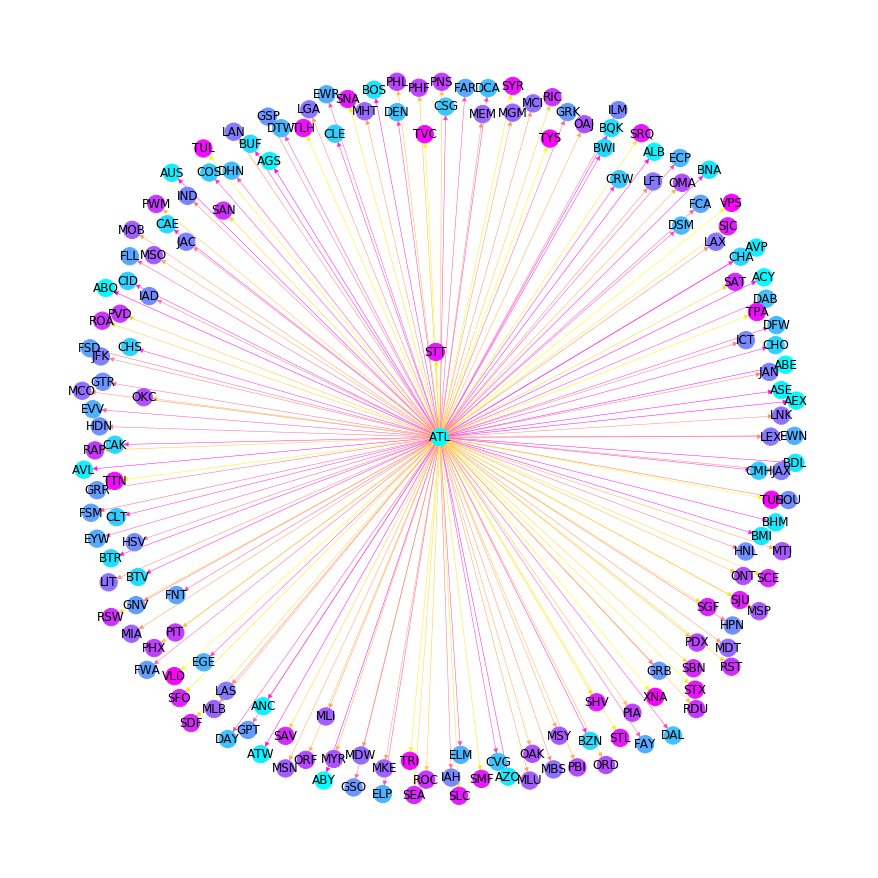

In [28]:
visualize_neighbors("ATL")